In [1]:
## Import libraries

In [2]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(scales)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# It is important to emphasize that some samples do not have timestamps because it is not provided 
# for 'scheduled' status. But, I dont know its reason.

In [4]:
df_log <- read.csv(file = 'events.csv', sep = ',', stringsAsFactors = FALSE)
df_log$first_timestamp <- as.POSIXct(df_log$first_timestamp,format='%Y-%m-%dT%H:%M:%SZ', tzone = "UTC")
df_log$timestamp <- as.numeric(df_log$first_timestamp)
df_log$timestamp[is.na(df_log$timestamp)] <- Inf

df_log <- df_log %>%
  group_by(uid) %>%
  mutate(min_timestamp = min(timestamp)) %>%
  ungroup()
summary(df_log)

     uid                name           function_name     
 Length:5           Length:5           Length:5          
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         
 first_timestamp               last_timestamp        reason         
 Min.   :2021-07-13 09:01:55   Length:5           Length:5          
 1st Qu.:2021-07-13 09:01:55   Class :character   Class :character  
 Median :2021-07-13 09:01:55   Mode  :character   Mode  :character  
 Mean   :2021-07-13 09:01:55                                        
 3rd Qu.:2021-07-13 09:01:55                                        
 Max.   :2021-07-13 09:01:55                                        
     node             message            timestamp         min_timestamp      
 Length:5           Length:5    

In [5]:
df_activations <- read.csv(file = 'activations.csv', sep = ',', stringsAsFactors = FALSE)
summary(df_activations)

  object_uid        object_name        function_name         duration    
 Length:3           Length:3           Length:3           Min.   :1.999  
 Class :character   Class :character   Class :character   1st Qu.:1.999  
 Mode  :character   Mode  :character   Mode  :character   Median :1.999  
                                                          Mean   :1.999  
                                                          3rd Qu.:1.999  
                                                          Max.   :1.999  
                                                          NA's   :2      
   timestamp            reason            node         message       
 Min.   :1.626e+09   Length:3           Mode:logical   Mode:logical  
 1st Qu.:1.626e+09   Class :character   NA's:3         NA's:3        
 Median :1.626e+09   Mode  :character                                
 Mean   :1.626e+09                                                   
 3rd Qu.:1.626e+09                                        

In [6]:
### Filter the events file

In [7]:
df_filtered <- df_log %>%
    filter(
      #eason == 'Scheduled' |
      reason == 'Pulling' |
      reason == 'Pulled' |
      reason == 'Created' |
      reason == 'Started' )

df_selected <- df_filtered %>%
    mutate(duration = abs(timestamp - min_timestamp)) %>%
    select(-name, -uid, -message, -min_timestamp, -first_timestamp, -last_timestamp, -timestamp)
summary(df_selected)

 function_name         reason              node              duration
 Length:4           Length:4           Length:4           Min.   :0  
 Class :character   Class :character   Class :character   1st Qu.:0  
 Mode  :character   Mode  :character   Mode  :character   Median :0  
                                                          Mean   :0  
                                                          3rd Qu.:0  
                                                          Max.   :0  

In [8]:
### Duration Analysis

In [9]:
df_spread <- df_selected %>%
    group_by_at(vars(-duration)) %>%
    mutate(sample_id = row_number()) %>% ungroup() %>%
    spread(reason, duration) %>%
    select(-sample_id) #%>%
    #mutate(
    #    Created = replace_na(Created,0),
    #    Pulled = replace_na(Pulled,0),
    #    Pulling = replace_na(Pulling,0),
    #    Started = replace_na(Started,0))

df_processed <- df_spread %>%
    group_by(function_name) %>%
    mutate(
        container_image_downloading = abs(Pulled - Pulling),
        container_image_creation = abs(Created - Pulled),
        container_initialization = abs(Started - Created)) %>%
    mutate(
        Created = replace_na(container_image_downloading,0),
        Pulled = replace_na(container_image_creation,0),
        Pulling = replace_na(container_initialization,0)) %>%
    select(
        function_name,
        node,
        container_image_downloading,
        container_image_creation,
        container_initialization)
head(df_processed)

function_name node         container_image_downloading
1 chameleon2    kind-worker2 0                          
  container_image_creation container_initialization
1 0                        0

In [10]:
### Filter the activations file

In [11]:
df_activations_selected <- df_activations %>%
    select(
        function_name,
        duration,
        reason,
        node,
        object_uid) #%>%
        #mutate(duration = (duration / 1000) %% 60)
summary(df_activations_selected)

 function_name         duration        reason            node        
 Length:3           Min.   :1.999   Length:3           Mode:logical  
 Class :character   1st Qu.:1.999   Class :character   NA's:3        
 Mode  :character   Median :1.999   Mode  :character                 
                    Mean   :1.999                                    
                    3rd Qu.:1.999                                    
                    Max.   :1.999                                    
                    NA's   :2                                        
  object_uid       
 Length:3          
 Class :character  
 Mode  :character  
                   
                   
                   
                   

In [12]:
### First view of activations

'data.frame':	3 obs. of  5 variables:
 $ function_name: chr  "chameleon2" "chameleon2" "chameleon2"
 $ duration     : num  2 NA NA
 $ reason       : chr  "function_execution" "finishing_time" "starting_time"
 $ node         : logi  NA NA NA
 $ object_uid   : chr  "c35110b5768741389110b57687c138e0" "c35110b5768741389110b57687c138e0" "c35110b5768741389110b57687c138e0"


Saving 6.67 x 6.67 in image

Warning message:
“Removed 2 rows containing missing values (position_stack).”
Warning message:
“Removed 2 rows containing missing values (position_stack).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


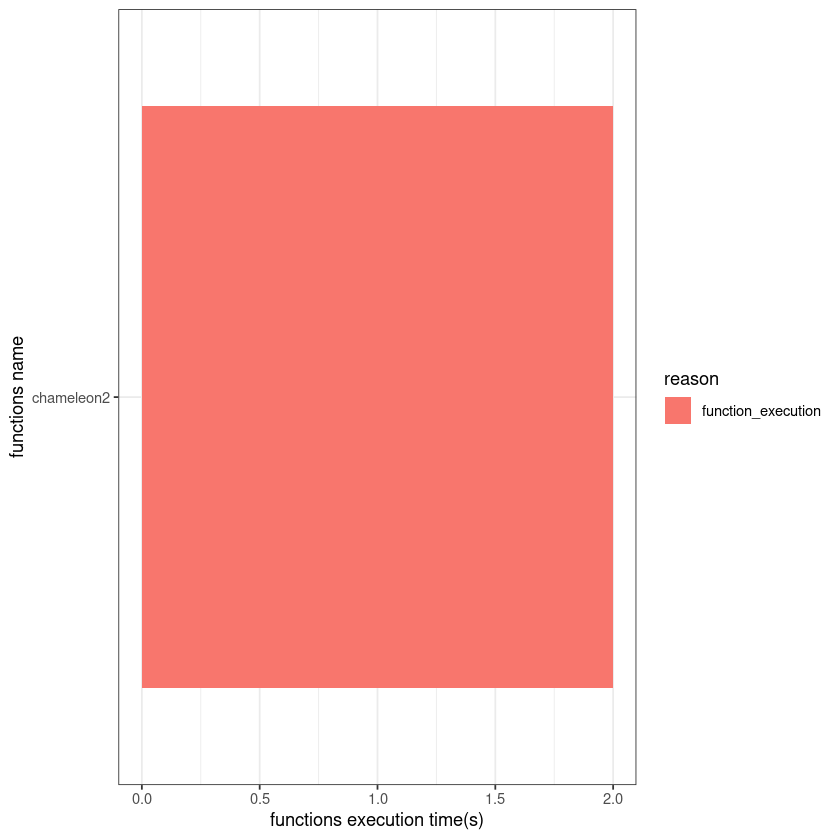

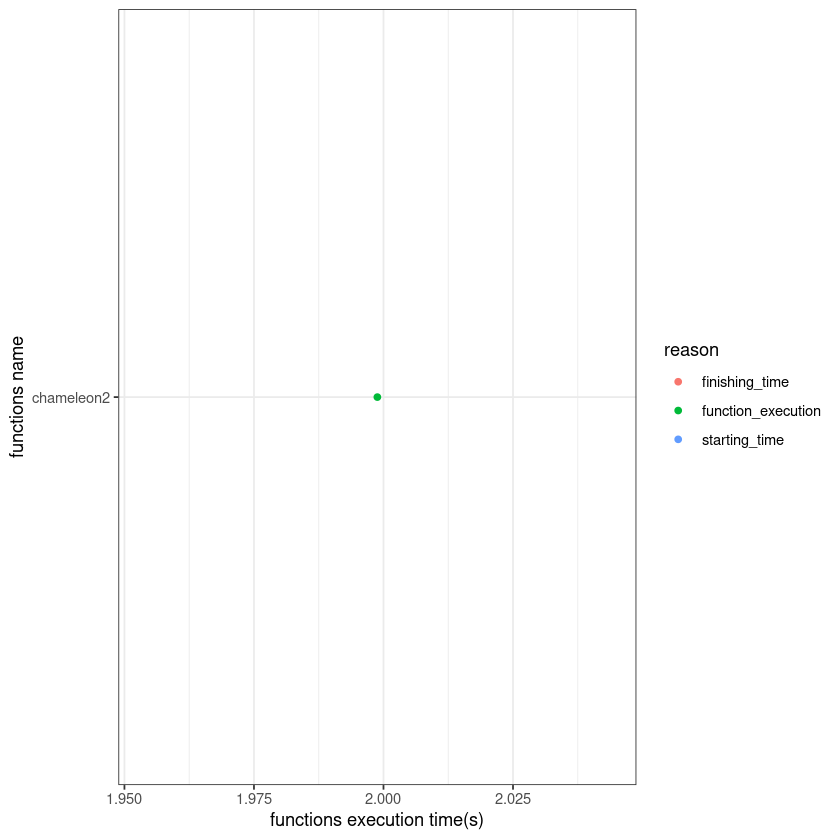

In [13]:
str(df_activations_selected)
df_plot <- df_activations_selected

ggplot(data = df_plot) +
   geom_bar(aes(x = duration, y = function_name, fill = reason),stat='identity')  +
   labs(x = "functions execution time(s)", y = "functions name") +
   theme_bw() +
   ggsave('activations_bar_plot.png')

ggplot(data = df_plot) +
   geom_point(aes(x = duration, y = function_name, color = reason),stat='identity')  +
   labs(x = "functions execution time(s)", y = "functions name") +
   theme_bw() +
   ggsave('activations_point_plot.png')

In [14]:
### Spread the timestamps of activations by categories

In [15]:
df_activations_selected <- df_activations %>%
    select(
       function_name,
       duration,
       reason) %>%
    drop_na()
    #mutate(duration = (duration / 1000) %% 60)
summary(df_activations_selected)

df_spread_activations <- df_activations_selected %>%
   group_by_at(vars(-duration)) %>%
   mutate(sample_id = row_number()) %>% ungroup() %>%
   spread(reason, duration) %>%
   select(-sample_id)

head(df_spread_activations)
tail(df_spread_activations)

 function_name         duration        reason         
 Length:1           Min.   :1.999   Length:1          
 Class :character   1st Qu.:1.999   Class :character  
 Mode  :character   Median :1.999   Mode  :character  
                    Mean   :1.999                     
                    3rd Qu.:1.999                     
                    Max.   :1.999                     

function_name function_execution
1 chameleon2    1.998817

function_name function_execution
1 chameleon2    1.998817

In [16]:
### Merge the activations and events data

In [17]:
df_events_to_join <- df_processed #%>% mutate(id = row_number())
head(df_events_to_join)
df_activations_to_join <- df_spread_activations #%>% mutate(id = row_number())
head(df_activations_to_join)

df_all <- full_join(
   df_events_to_join,
   df_activations_to_join,
   by="function_name") #%>%
   #distinct()
df_all[is.na(df_all)] = 0

#head(df_all)

#df_renamed <- df_all %>%
#    group_by(object_uid) %>%
#    mutate(function_name = paste(function_name, '_', substr(object_uid, 1, 4))) %>%
#    ungroup() %>%
#    select(-object_uid)
#head(df_renamed)

df_gathered <- df_all %>%
    gather(
        factor_key = 'TRUE',
        key = 'reason',
        value = 'duration',
        -function_name, -node) 
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_image_downloading', '00_container_image_downloading')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_image_creation', '01_container_image_creation')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'container_initialization', '02_container_initialization')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'download_data', '03_download_data')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'function_execution', '04_function_execution')
df_gathered$reason <- str_replace_all(df_gathered$reason, 'upload_data', '05_upload_data')

df_plot <- df_gathered
head(df_plot)
tail(df_plot)
#summary(df_plot)
#str(df_plot)

function_name node         container_image_downloading
1 chameleon2    kind-worker2 0                          
  container_image_creation container_initialization
1 0                        0

function_name function_execution
1 chameleon2    1.998817

function_name node         reason                         duration
1 chameleon2    kind-worker2 00_container_image_downloading 0.000000
2 chameleon2    kind-worker2 01_container_image_creation    0.000000
3 chameleon2    kind-worker2 02_container_initialization    0.000000
4 chameleon2    kind-worker2 04_function_execution          1.998817

function_name node         reason                         duration
1 chameleon2    kind-worker2 00_container_image_downloading 0.000000
2 chameleon2    kind-worker2 01_container_image_creation    0.000000
3 chameleon2    kind-worker2 02_container_initialization    0.000000
4 chameleon2    kind-worker2 04_function_execution          1.998817

In [18]:
### Plot the merged data

Saving 6.67 x 6.67 in image



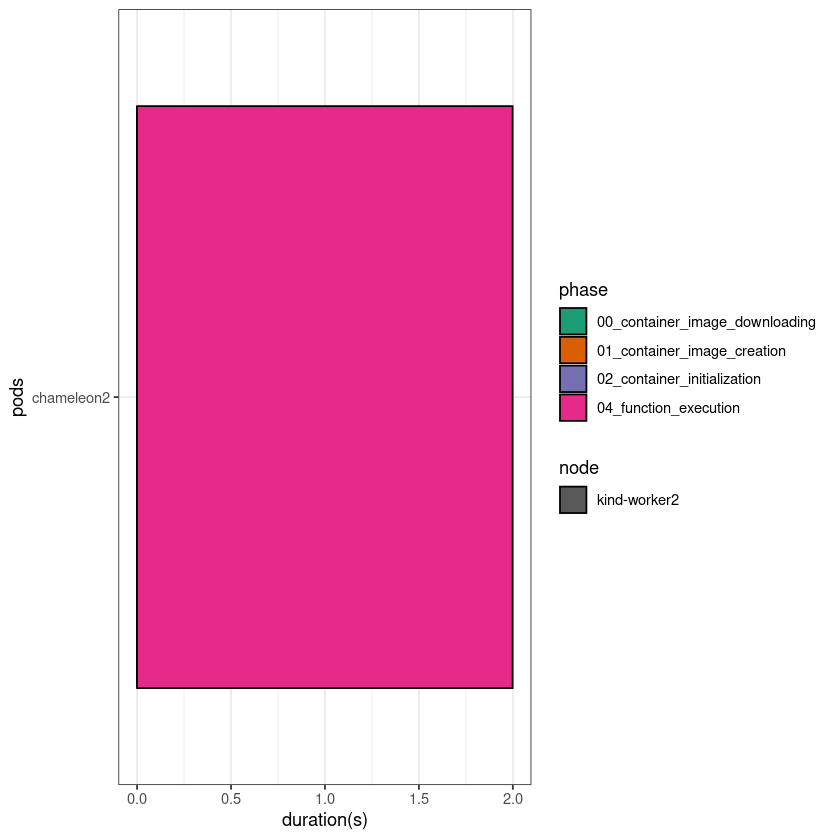

In [19]:
ggplot(data = df_plot, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack.png')

Saving 6.67 x 6.67 in image



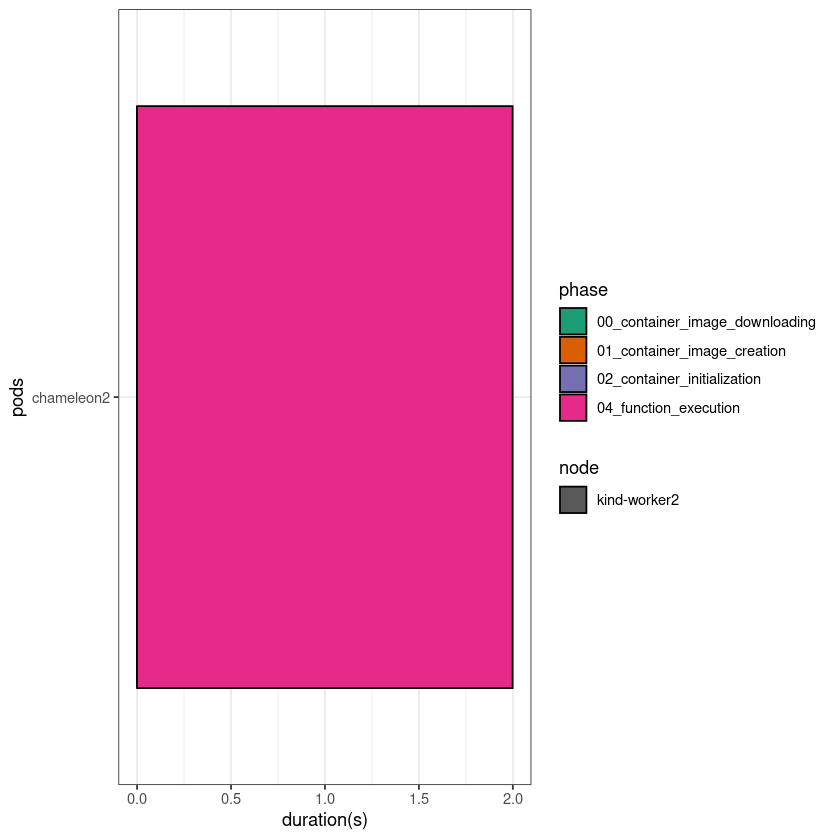

In [20]:
df_plot2 <- df_plot %>% filter(function_name != 'videoprocessing1' & function_name != 'videoprocessing2' & function_name != 'videoprocessing3' &
                              function_name != 'imageprocessing1' & function_name != 'imageprocessing2' & function_name != 'imageprocessing3')

ggplot(data = df_plot2, aes(x = duration, y = function_name, fill = reason, linetype = node))+#, color = node)) +
   geom_bar(stat='identity', position = position_stack(reverse = TRUE), color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   scale_fill_brewer(palette = "Dark2") +
   theme_bw() +
   ggsave('full_bar_plot_stack_filtered.png')

Saving 6.67 x 6.67 in image



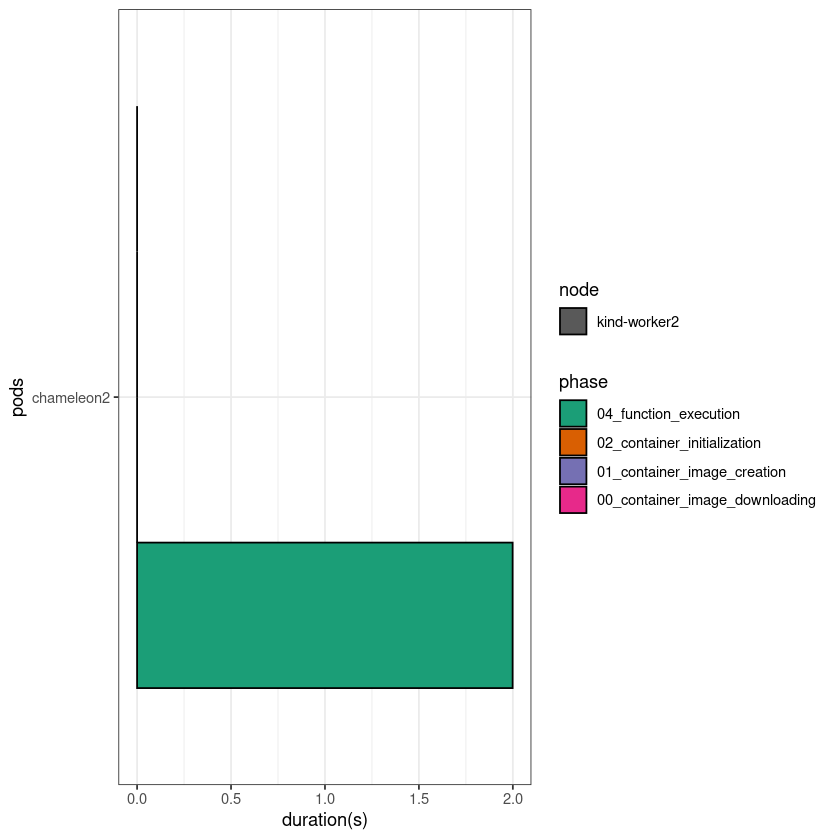

In [21]:
ggplot(data = df_plot, aes(x = duration, y = function_name, linetype = node,
                           fill = factor(reason, levels = rev(c("00_container_image_downloading",
                                  "01_container_image_creation", 
                                  "02_container_initialization", 
                                  "03_download_data", 
                                  "04_function_execution", 
                                  "05_upload_data"))))) +#, color = node)) +
   geom_bar(position="dodge", stat='identity', color = "black")  +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   theme_bw() +
   scale_fill_brewer(palette = "Dark2") +
   #guides(fill = guide_legend(reverse = TRUE))
   ggsave('full_bar_plot_dodge.png')

Saving 6.67 x 6.67 in image

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 3 rows containing missing values (geom_bar).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 3 rows containing missing values (geom_bar).”


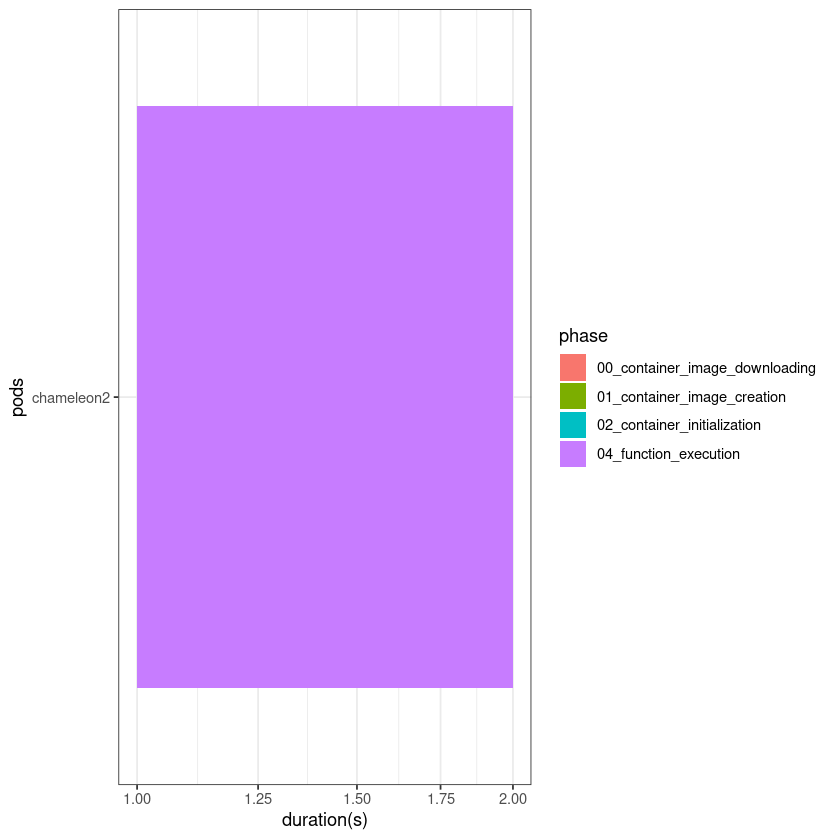

In [22]:
ggplot(data = df_plot, aes(x = duration, y = function_name, fill = reason))+#, color = node)) +
   geom_bar(stat='identity')  +
    scale_x_log10() +
   labs(x = "duration(s)", y = "pods", fill = "phase") +
   theme_bw() +
   ggsave('full_bar_plot_log10.png')

Saving 6.67 x 6.67 in image



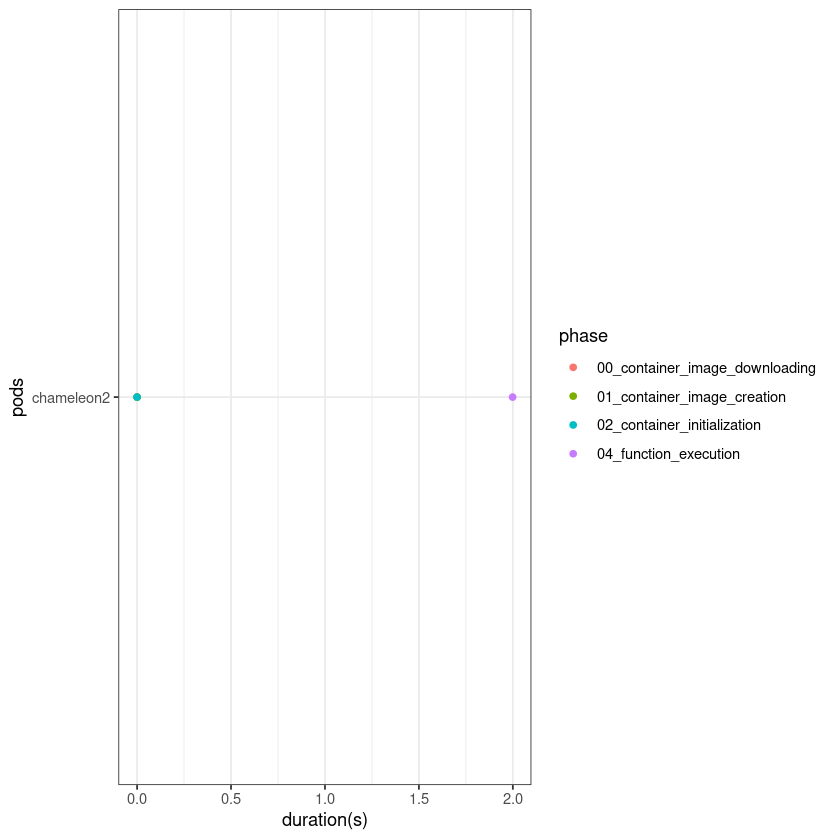

In [23]:
ggplot() +
    geom_point(data = df_plot, aes(x = duration, y = function_name, color = reason))+#, color = reason)) +
    labs(x = "duration(s)", y = "pods", color = "phase") +
    theme_bw() +
    ggsave('full_geom_point.png')

Saving 6.67 x 6.67 in image

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


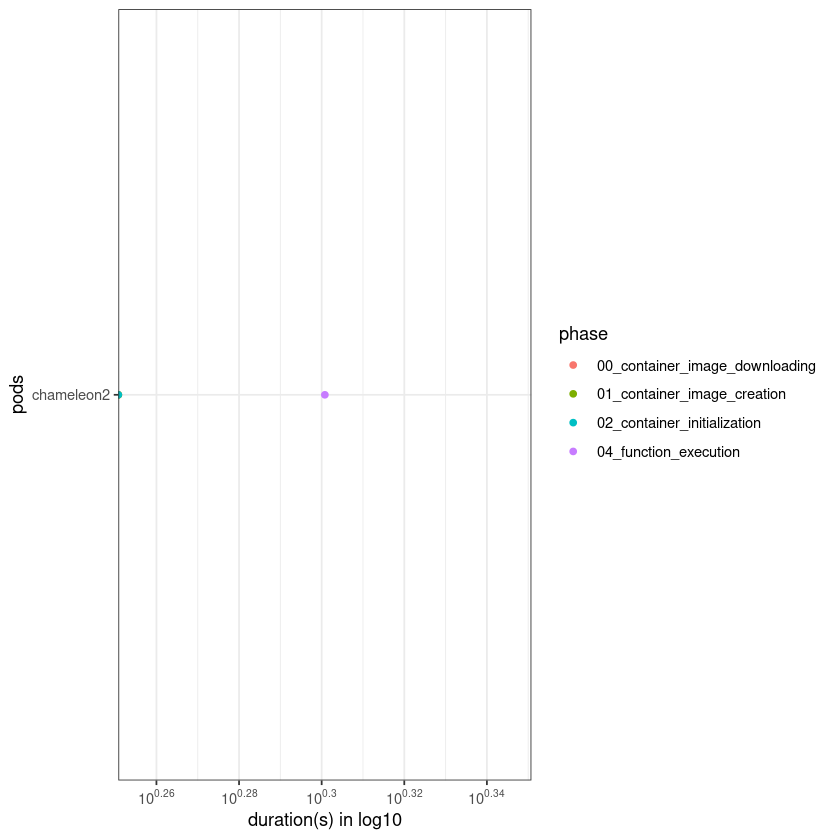

In [24]:
ggplot() +
    geom_point(data = df_plot, aes(x = duration, y = function_name, color = reason))+#, color = reason)) +
    labs(x = "duration(s) in log10", y = "pods", color = "phase") +
    scale_x_log10(breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))) +
    theme_bw() +
    ggsave('full_geom_point_log10.png')